# Coding Theory for Storage and Networks
## Lab on Interleaved Reed-Solomon Codes

Student: David de Andres Hernandez

Student Number: 03755457

## Task 1 Homogeneous Interleaved Reed-Solomon Code
Let $C_1$ denote an $IRS$ code consisting of $l=2$ Reed–Solomon codes $RS(15, 8)$ over $F_{2^4}$.
Assume that the codewords of $C_1$ were transmitted over a bursty channel and we therefore choose a common error-locator polynomial for both Reed–Solomon (RS) codes in the decoding process.

In [1]:
# Define the field order
# We work in the Galois Field GF(16)=GF(2^4)
p = 2
m = 4
q = p^m
F.<a> = GF(q, modulus = 'primitive')
# IRS code
l_1 = 2 # number of rows of IRS code
n = q - 1 # code length
# The information length can be chosen
k_1 = 8
# Given evaluation points and a RS construction
L = [a^i for i in range(n)]
RS1 = codes.GeneralizedReedSolomonCode(L, k_1)
# As RS codes are MDS, the minimum Hamming distance can be computed
# directly using the Singleton bound.
dmin_1 = n - k_1 + 1

Polys  = F['x']
#alphas = [a^i for i in range(n)]


### Task 1.1 Calculate maximum number of errors decodable using IRS codes.

In [2]:
tmax_1 = floor(l_1/(l_1+1)*(dmin_1-1))
assert tmax_1 == 4, "Maximum decoding radius is wrong."

### Task 1.2  Add info_12, c_12, y_12, s_12 for second RS(15,8) code at the orresponding places.
In the file IRS.sage, 4 random information vectors info 1x are given, compute the
corresponding codewords c 1x.
2 error vectors occur and the resulting received words are given y 1x. Compute the
corresponding syndromes s 1x

In [3]:
# Given 4 random information vectors over GF(2^m) of length k.
info_11 = random_vector(F, k_1)
info_12 = random_vector(F, k_1)
info_13 = random_vector(F, k_1)
info_14 = random_vector(F, k_1)
# Encode the information word using the generator matrix of the given RS code.
G1 = RS1.generator_matrix()
c_11 = info_11*G1
c_12 = info_12*G1
c_13 = info_13*G1
c_14 = info_14*G1

In [4]:
print(c_11)

(a^3 + a^2 + a, a^2, 1, a, a^3 + a^2, a^2 + a, a^2 + a + 1, 0, a^3 + a^2 + 1, a, 1, a + 1, a^3 + a^2, a^2 + a, a^3 + a^2 + a + 1)


In [5]:
# Create error vectors
e_11 = vector(F, n)
e_11[1] = a^2
e_11[5] = a^4
e_11[9] = a^10
e_11[10] = a^3

error_pos = [i for i in range(0, n) if not e_11[i].is_zero()]
print(error_pos)


e_12 = vector(F, n)
e_12[1] = a^6
e_12[5] = a^7
e_12[9] = a^2
e_12[10] = a^3

[1, 5, 9, 10]


In [6]:
# Add the error to the codeword to obtain the received vector
y_11 = c_11 + e_11
y_12 = c_12 + e_12
y_13 = c_13 + e_11
y_14 = c_14 + e_12

# Calculate the syndromes.
H1 = RS1.parity_check_matrix()
s_11 = y_11 * H1.transpose()
s_12 = y_12 * H1.transpose()
s_13 = y_13 * H1.transpose()
s_14 = y_14 * H1.transpose()

assert s_11 == s_13, "s_11 and s_13 should be equal."
assert s_12 == s_14, "s_12 and s_14 should be equal."

### Task 1.3 Implement a function irs_decoding() that returns the error positions given the syndrome.
Hint: construct and solve the linear system of equations for finding the error locator
polynomial. Find the roots of the error locator polynomial to find the error locations.

In [7]:
def irs_decoding(F, tmax, synd_vec):
    """
    locate the errors by solving the linear system of equations
    Input parameters:
        F: the Field
        tmax: Maximum number of errors decodable by IRS codes
        synd_vec: Syndrome vectors
    Return values:
        errloc: locations of the errors
        t: Actual number of errors
    """
    t = tmax
    
    S = None
    T = None
    
    for i, synd in enumerate(synd_vec):        
        if S == None:
            S = matrix(F, len(synd)-t, t, lambda i,j: synd[t-1-j+i])
            T = vector([synd[t+i] for i in range(len(synd)-t)])
        else:
            S2 = matrix(F, len(synd)-t, t, lambda i,j: synd[t-1-j+i]) # Set up syndrome matrix S
            S = S.stack(S2)
            T2 = vector([synd[t+i] for i in range(len(synd)-t)])
            T = vector(T.list() + T2.list())
    
    while(S.rank() < t): # Determine the rank of S 
        t=-1 # if < tmax errors happened, the rank would be <t and we would need to decrease tmax
        
        S = None
        T = None

        for synd in synd_vec:
            if S == None:
                S = matrix(F, len(synd)-t, t, lambda i,j: synd[t-1-j+i])
                T = vector([synd[t+i] for i in range(len(synd)-t)])
            else:
                S2 = matrix(F, len(synd)-t, t, lambda i,j: synd[t-1-j+i]) # Set up syndrome matrix S
                S = S.stack(S2)
                T2 = vector([synd[t+i] for i in range(len(synd)-t)])
                T = vector(T.list() + T2.list())
    
    lambdavec = S.solve_right(-T)			# Obtain Lambda_1,...,Lambda_t
    ELP = Polys([1]+lambdavec.list())		# Compute Lambda(x)
    
    errloc = [l for l in range(n) if ELP(L[l]^-1)==0]	# Find the error positions by evaluating Lambda(x) at all alphas[l]^-1

    return errloc, t

In [8]:
# Calculate the error positions.
errloc, t = irs_decoding(F, tmax_1, [s_13, s_14])
errloc.sort()
print(t)

assert errloc == [1,5,9,10], "Error locations are wrong."
print('Error positions:\n %s' % errloc)

4
Error positions:
 [1, 5, 9, 10]


## Task 2 Heterogeneous Interleaved Reed-Solomon Code
We extend $C_1$ to a heterogeneous IRS code $C_2$ of interleaving order $l = 3$ by adding an RS code over $F_{2^
4}$ of length $n = 15$ and dimension $k_2 = 6$. We assume one common error-locator polynomial for all three RS codes.

In [9]:
k_2 = 6
# Create the RS code for the given k_2
RS2 = codes.GeneralizedReedSolomonCode(L, k_2)
# encode the random info_2 using generator matrix
G2 = RS2.generator_matrix()
info_2 = random_vector(F, k_2)
c_2 = info_2 * G2

In [10]:
# error vector
e_2 = vector(F, n)
e_2[1] = a^2
e_2[5] = a^3
e_2[9] = a^1
e_2[10] = a^9
e_2[12] = a^4
e_11[12] = a
e_12[12] = 1
# Add the error to the codeword to obtain the received vector.
y_2 = c_2 + e_2
y_11 = c_11 + e_11
y_12 = c_12 + e_12

### Task 2.1 Calculate maximum number of errors decodable.
What is the decoding radius $t_{max,2}$ of $C_2$?

In [11]:
k_mean = mean([k_1, k_1, k_2])
l_2 = 3
tmax_2 = floor(l_2/(l_2+1)*(n-k_mean))
print("t_max,2 = ", tmax_2)

t_max,2 =  5


### Task 2.2 Calculate the syndrome $S_2$ corresponding to the additional RS code.
Calculate the syndromes s11, s12, s2 corresponding to the new error vector given in
the file IRS.sage

In [12]:
H2 = RS2.parity_check_matrix()
s_2 = y_2 * H2.transpose()
s_11 = y_11 * H1.transpose()
s_12 = y_12 * H1.transpose()

### Task 2.3 Calculate the error positions using system of equations.
Use the function irs decoding() to find the error locations.

In [13]:
errloc, t = irs_decoding(F, tmax_2, [s_2, s_11, s_12])
errloc.sort()
assert errloc == [1,5,9,10,12], "Error locations are wrong."
print('Error positions of heterogeneous IRS:\n %s' % errloc)

Error positions of heterogeneous IRS:
 [1, 5, 9, 10, 12]


### Task 2.4 Do we need the syndromes of all three RS codes for the decoding?

No, we don't need all the syndromes, as $t_{max}=5$, we only need 5 equations. With $s_2$ and $s_{11}$ we already have 6 equations for decoding.

## Task 3: Virtual Interleaving (Power Decoding)
In order to decode the RS(15, 2) code over $F_{2^4}$ beyond half the minimum distance, we extend it virtually to a heterogeneous IRS code.

In [14]:
k = 2;
RS4 = codes.GeneralizedReedSolomonCode(L, k)
# Create a random information word over GF(2^m) of length k.
info = random_vector(F, k)

# Encode the information word using generator matrix of a RS code.
G4 = RS4.generator_matrix()
c = info * G4

# errors happen at index = 0,2,3,4,6,9,11,13,14
e = vector(F, [a^5, 0, a^2, a^6, a^1, 0, a, 0, 0, a^5, 0, a^6, 0, a^7, a^9])

# Add the error to the codeword to obtain the received vector.
y = c + e

### Task 3.1
Calculate the maximum decoding radii for all virtual interleaving orders i = 2,...,6. Determine the sufficient virtual interleaving order.

In [15]:
t_max_l = {}
for i in range(2,7):
    k_avg = ((k - 1) * (i + 1)) / 2 + 1
    t_max_i = floor((i/(i+1))*(n-k_avg))
    t_max_l[i] = t_max_i
    print(f'i={i}, t_max({i}) = {t_max_i}') 

i=2, t_max(2) = 8
i=3, t_max(3) = 9
i=4, t_max(4) = 9
i=5, t_max(5) = 9
i=6, t_max(6) = 9


In [16]:
i_max = max(t_max_l, key=t_max_l.get)
t_max = t_max_l[i_max]
#i_max = max(range(len(t_max_l)), key=t_max_l.__getitem__)
print(f't_max = {t_max}')
print(f'l = {i_max}')

t_max = 9
l = 3


In [17]:
print(y.apply_map(lambda x: x^2))
print(y)

(a + 1, a^3 + a^2 + a, a + 1, a, a^3, a^3, a^3 + a^2 + a + 1, a^2 + a + 1, a, a, a^3 + a, a^3 + a^2, 1, 0, a^2 + a + 1)
(a^2, a^3 + a^2 + 1, a^2, a^2 + 1, a^3 + a, a^3 + a, a^3 + a^2, a^2 + a, a^2 + 1, a^2 + 1, a^3 + a^2 + a + 1, a^3, 1, 0, a^2 + a)


### Task 3.2
Complete the function Power_dec() for power decoding algorithm.

In [18]:
def Power_dec(F, k, y, t_max, i_max):
    """
    Perform power decoding for a received RS codeword. i.e. construct a virtual IRS by
    powering the RS codeword, then do IRS decoding.
    Inputs:
        F: the finite field
        k: the dimension of the RS code
        y: the received RS codewords
        t_max: the maximum decoding radius
        i_max: the sufficient virtual interleaving order to obtain tmax
    """
    L = [a^i for i in range(n)] # evaluation points for RS code construction
    s_vec = [] # list of syndromes of virtual IRS code
    for i in range(1, i_max + 1):
    # The power decoding algorithm has to do the following steps:
        # Calculate element-wise power of the received word
        y_i = y.apply_map(lambda x: x^i)

        # Calculate the dimensions of virtual codes
        k_i = i * (k - 1) + 1
        RS_i = codes.GeneralizedReedSolomonCode(L, k_i)

        # Calculate original syndrome and virtual syndromes
        H_i = RS_i.parity_check_matrix()
        s_vec.append(y_i * H_i.transpose())
    # Calculate the error locations using irs_decoding()
    [errloc, t] = irs_decoding(F, t_max, s_vec)

    return errloc, t

In [19]:
errloc, t = Power_dec(F, k, y, t_max, i_max)
errloc.sort()
assert errloc == [0,2,3,4,6,9,11,13,14], "Error locations are wrong."
print('Error positions of virtual extension:\n %s' % errloc)

Error positions of virtual extension:
 [0, 2, 3, 4, 6, 9, 11, 13, 14]


## Problem 4: Decoding Failure
As discussed in the lecture, the virtual interleaving principle can results in a decoding failure

### Task 4.1
Run power decoding over 1000 random error vectors of length 15 and weight $t_{max}$ and calculate the failure probability of power decoding.

*Hint: adapt the function irs_decoding() to raise an error when the decoding fails.*

In [20]:
import random

def calculate_failure_chances(n, t_max, report=False):
    iterations = 1000
    fail = 0

    pad_length = n - t_max
   
    it = 0
    while it < iterations:

        weight = 0
        error = random_vector(F, n)
        zeroes = error.list().count(0)
        if zeroes != pad_length:
            zero_pos = random.sample(range(n), pad_length-zeroes)
            for j in  zero_pos:
                if(error[j] != 0):
                    error[j] = 0
                else:
                    error[random.sample(range(n), 1)[0]] = 0
                    
        for idx, element in enumerate(error.list()):
            if element != 0:
                weight += 1
        
        if weight != t_max:
            #print(f'weigth > t_max:{weight}>{t_max}')
            continue
            
        #print(error)
        #print(weight)
        y = c + error
        
        try:
            Power_dec(F, k, y, t_max, i_max)
        except:
            fail += 1
        it+=1
        
    if report:
        print(f'{fail} Power decoding attempts from {iterations} failed')
    return fail, it
    # In each iteration, create a random error vector of weight t_max and add to
    # the codeword generated in Task 3. Decode the erroneous word using power decoding
    # and count decoding failures.
    # Hint: use try-except to catch the errors.

In [21]:
fail, iteration = calculate_failure_chances(n, t_max, True)

70 Power decoding attempts from 1000 failed


In [22]:
# Calculate the decoding failure probability for error of weight tmax
probfail = RealField(20)(100*fail/iteration)
# Compare the result with the estimation from the lecture.
probfail_est = RealField(20)(100*1/(q-1))
print('Probability of failure: %s %%' % probfail)
print('Estimated probability of failure: %s %%' % probfail_est)

Probability of failure: 7.0000 %
Estimated probability of failure: 6.6667 %


The results yield percentages in the range $(7,10)\%$ which is not bad, but deviates from the expected value $6.6667\%$. This can be because of some imperfections in the power decoding algorithm which may raise some exceptions which are treated as decoding failure erroneously.

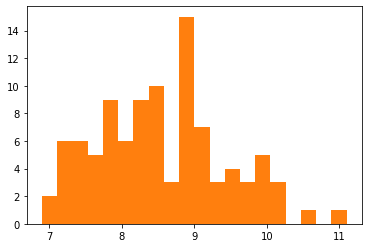

In [23]:
import matplotlib.pyplot as plt
probs=[]
runs = 100
for run in range(runs):
    try:
        fail, iteration = calculate_failure_chances(n, t_max)
    except:
        continue
    probfail = RealField(20)(100*fail/iteration)
    probs.append(probfail)

counts, bins, _ = plt.hist(probs, bins=20)
plt.hist(probs, bins=bins)
plt.show()